# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm

## Read data 

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

In [3]:
lbldf.loc['gdp_growth']

label     Annual growth in GDP per capita, 1970-2020
source                                            WB
Name: gdp_growth, dtype: object

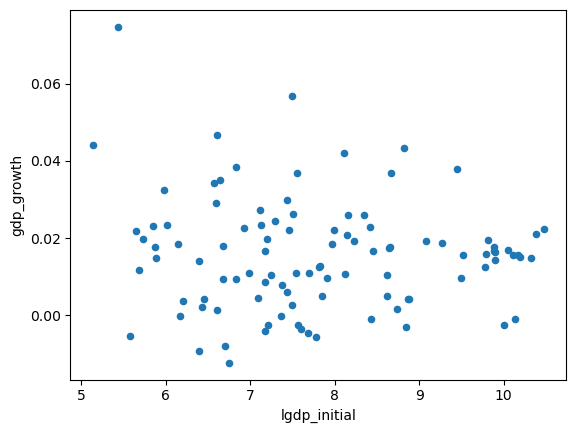

In [4]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

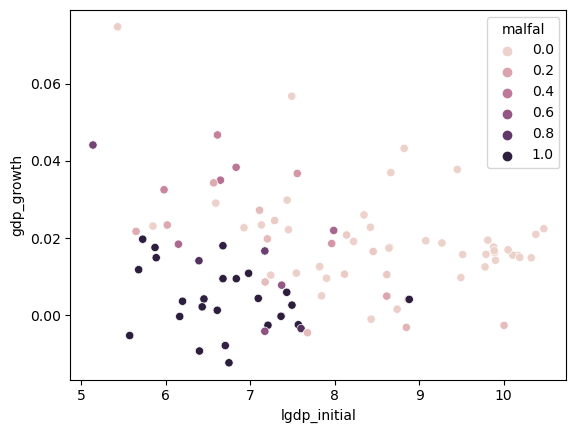

In [5]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [6]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [7]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Simple OLS

In [8]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [9]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# Convert NaN values in X to zero
X = np.nan_to_num(X, nan=0.0)

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

In [10]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


In [11]:
def standardize(X):
    print(f"Input X shape: {X.shape}")
    print(f"NaNs in input X: {np.isnan(X).sum()}")
    
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    
    print(f"Any zero/near-zero sigma? {np.any(sigma < 1e-10)}")
    
    # Check for columns with zero variance
    zero_var_cols = np.where(sigma < 1e-10)[0]
    if len(zero_var_cols) > 0:
        print(f"Columns with zero/near-zero variance: {zero_var_cols}")
    
    # Handle standardization carefully
    X_tilde = X.copy()
    for i in range(X.shape[1]):
        if sigma[i] > 1e-10:  # Only standardize columns with variance
            X_tilde[:, i] = (X[:, i] - mu[i]) / sigma[i]
        else:  # Keep constant columns as they are (or set to 0)
            X_tilde[:, i] = X[:, i]  # Keep the constant value
    
    print(f"NaNs in output X_tilde: {np.isnan(X_tilde).sum()}")
    return X_tilde

# Check X before standardization
print(f"X shape: {X.shape}")
print(f"NaNs in X before standardization: {np.isnan(X).sum()}")

X_tilde = standardize(X)

X shape: (89, 28)
NaNs in X before standardization: 0
Input X shape: (89, 28)
NaNs in input X: 0
Any zero/near-zero sigma? True
Columns with zero/near-zero variance: [27]
NaNs in output X_tilde: 0


In [12]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 80000, num = 50)

coefs=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(X_tilde,y) 
    coefs.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

In [13]:
def plot_lasso_path(penalty_grid, coefs, legends, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    coefs (array-like): The estimated coefficients for each penalty value.
    legends (list): The labels for each coefficient estimate.
    vlines (dict, optional): A dictionary of vertical lines to add to the plot. The keys are the names of the lines and the values are the penalty values where the lines should be drawn.
    
    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot coefficients as a function of the penalty parameter
    ax.plot(penalty_grid, coefs)

    # Set log scale for the x-axis
    ax.set_xscale('log')

    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    plt.title('Lasso Path')

    # Add legends
    lgd=ax.legend(legends,loc=(1.04,0))
    
    # Add vertical lines
    if vlines is not None:
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            plt.text(penalty,-80000,name,rotation=90)

    # Display plot
    plt.show()
    plt.close()


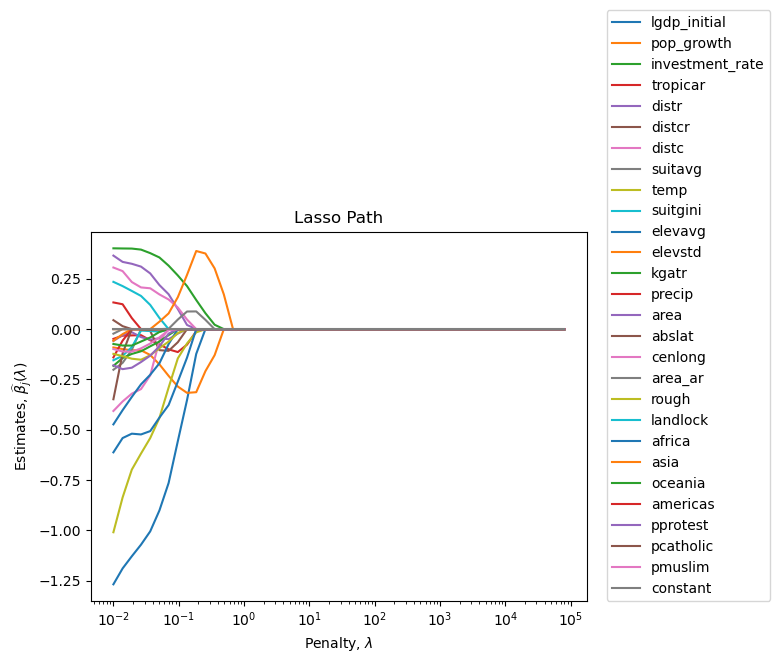

In [15]:

# Plot lasso path
plot_lasso_path(penalty_grid, coefs,    xs,)